In [1]:
# Version: 0.0.1
# Date:    2022-07-22
# Author:  P. J. Vetter, Timo Joas
# Email=  philipp.vetter@uni-ulm.de;

In [1]:
# Simulation to investigate the robustness of the optimal control pulse. 
# Pulse units are abstracted away by imported ArbPulse class

# The oc_element function reads in the pulse files and creates the corresponding pulse

# all possible initial states are defined in the 'Initial State' section
# density matrix of the m_s = 0 state: rho_ms0 
# density matrix of the m_s = -1 state: rho_msm1
# density matrix of the x state: rho_x
# density matrix of the y state: rho_y

# (The first run might take a bit longer due to the plot generation)

# Packages

In [1]:
import os
os.getcwd()

'C:\\Software\\qudi\\user_scripts\\Timo\\own\\optimalcontrol'

In [2]:
#%matplotlib notebook
#%matplotlib notebook

import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from scipy import interpolate
import matplotlib as mpl

from oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

plt.rcParams.update({'font.size': 30})  

# Library

In [3]:
def demod_iq_simple(samples, f_carrier, t):
    # integrate the following equation over N periods and assume that f(I) << f
    # s= I*sin(ft) + Q*cos(ft) | *sin
        
    f = f_carrier
    t_per = 1/f
    n_per = int(np.round(t[-1] / t_per))
    idx_t_per = int(np.argmin(abs(t_per - t)))


    i, q = [], []
    for idx in range(0, n_per):
        i_start = idx*idx_t_per
        i_end = (idx+1)*idx_t_per
        s = samples[i_start:i_end]
        ts = 2*np.pi*f*t[i_start:i_end]

        i.append(np.trapz(s*np.sin(ts))/np.pi)
        q.append(np.trapz(s*np.cos(ts))/np.pi)
    
    return i,q

def get_f_limits(f_res, f_centers_block, df=10e6, symm_block=False):
    f_centers_block_mhz = 1e-6 * np.asarray(f_centers_block).flatten()
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    freqs = []
    if symm_block:
        deltas = []
        for f_mhz in f_centers_block_mhz:
            deltas.append(abs(f_mhz - f_res_mhz))
        
        f_centers = []
        for d_mhz in deltas:
            f_center_2_mhz_min = f_res_mhz - d_mhz
            f_center_2_mhz_plus = f_res_mhz + d_mhz
            f_centers.append(f_center_2_mhz_min)
            f_centers.append(f_center_2_mhz_plus)
    else:
        f_centers = f_centers_block_mhz

    for f in f_centers:
        freqs.append([1e6*(f-df_mhz), 1e6*(f+df_mhz)])
    return freqs
    
def calc_crosstalk_penalty(freqs, spin_pop, f_res, f_center_block, df, symm_block=False, fac_penalty=1):

    
    idxs = np.empty((0), dtype=int)
    for (f_min, f_max) in get_f_limits(f_res, f_center_block, df, symm_block=symm_block):      
        idxs = np.append(idxs, np.where(np.logical_and(freqs >= f_min, freqs <= f_max)))
    
    #return idxs
    spin_pop = np.mean(spin_pop[idxs])
    
    # as in optimalcontrol_quocs.ipynb
    fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
    
    return fom_sim

def partial_trace(rho, sub=0, dims=None):
    if dims is None:
        dims = [[2,2],[2,2]]
    return np.asarray(qutip.Qobj(rho, dims=dims).ptrace(sub))    

def swap_basis_def(rho):
    # Genkos state definition is different!
    return np.rot90(rho,2).T

def sample_pulse_timegrid(pulse, f_carrier, sample_rate=None):
    timegrid_pulse = pulse.get_timegrid(unit='s')
    t_pulse = timegrid_pulse[-1]
    if sample_rate is None:
        dt_sample = 1/pulsedmeasurementlogic.pulsegenerator().get_sample_rate()
    else:
        dt_sample = 1/sample_rate
    timegrid_sampling = np.arange(0, t_pulse, dt_sample)
    
    return timegrid_sampling
    

def sample_pulse(pulse, f_carrier, sample_rate=None, phase_carrier_rad=0):
    timegrid_pulse = pulse.get_timegrid(unit='s')
    timegrid_sampling = sample_pulse_timegrid(pulse, f_carrier, sample_rate)
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    
    amplitude_func = interpolate.interp1d(timegrid_pulse, amplitude)
    phase_func = interpolate.interp1d(timegrid_pulse, phase)
    samples_arr = _get_sine_func(timegrid_sampling, amplitude_func, f_carrier, phase_carrier_rad, phase_func)
    
    return samples_arr


def _get_sine_func(time_array, amplitude_func, frequency, phase_rad, phase_func):
    samples_arr = amplitude_func(time_array - time_array[0]) * np.sin(2*np.pi * frequency * time_array + phase_rad) \
                  + phase_func(time_array - time_array[0]) * np.cos(2*np.pi * frequency * time_array + phase_rad)

    return samples_arr


def get_rescale_factor_ampl(pulse, f_carrier, max_ampl_v=0.25, sample_rate=None):
    # shaddows qudi::sampling_func
    
    # sampling for the awg has an unknown pulse position and hence phase
    # make sure that the pulse works for all phases by calculating rescale factor for worst case
    phases_rad = np.linspace(0, 2*np.pi, 100)
    samples_arr = sample_pulse(pulse, f_carrier, sample_rate=sample_rate)
    for ph in phases_rad:
        samples_curr = sample_pulse(pulse, f_carrier, phase_carrier_rad=ph, sample_rate=sample_rate)
        if np.max(samples_curr) > np.max(samples_arr):
            samples_arr = samples_curr
            #logger.debug(f"New max pulse ampl {np.max(samples_curr)} for phase {ph/np.pi} pi")
            
    max_sample_before = np.max(samples_arr)
    
    # avoid re-scaling by the pg, todo: think of better way
    import scipy
    if max(abs(samples_arr)) > 0.25:
        biggest_val = max([abs(np.min(samples_arr)), np.max(samples_arr)])
        mapper = scipy.interpolate.interp1d([-biggest_val, biggest_val], [-max_ampl_v, max_ampl_v])
        samples_arr = mapper(samples_arr)
        
    max_samples_after = np.max(samples_arr)
    
    return max_samples_after/max_sample_before
    
0

0

# Variables

In [5]:
# magnetic field [G]
B = 90

## Load pulses

In [16]:
1/1.27*0.25

0.19685039370078738

In [45]:



folder = r"input_pulses\rect"
name = "rec_amp_20MHz_0.025mus_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='µs', unit_data='MHz')

#folder = r"input_pulses"
#name = "on_nv=2_"

folder = r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
name = "opt_res_"
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*20,
                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*20))

folder = r"C:\Software\qudi_data\optimal_control_assets\_fromJuelich\20221013_1_pi\rescaled_3"
#folder = r"C:\Software\qudi_data\optimal_control_assets"
name = "on_nv=1_"
#name = "jul_res_on_nv=1_"
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/(1/1.27*0.25)*1/59.5e-9)
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/(1/1.27*0.25)*1/59.5e-3)

#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/1*80)

#folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
#name = "Opt_Pulse_01_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='ns', unit_data='MHz')


# loading experimental pulse
# 0.25 = 20 MHz
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s',  func_ampl_v_2_omega_mhz=lambda x: x/0.25*20)


#pulse = TimeDependentSimulation.load_pulse(folder, name, func_t_2_us=lambda t: t*1e6)
#
pulse.as_dict()




{'name': 'on_nv=1_',
 'folder': 'C:\\Software\\qudi_data\\optimal_control_assets\\_fromJuelich\\20221013_1_pi\\rescaled_3',
 'file': ['C:\\Software\\qudi_data\\optimal_control_assets\\_fromJuelich\\20221013_1_pi\\rescaled_3\\on_nv=1_amplitude.txt',
  'C:\\Software\\qudi_data\\optimal_control_assets\\_fromJuelich\\20221013_1_pi\\rescaled_3\\on_nv=1_phase.txt'],
 'timegrid_unit': 's',
 'data_unit': 'V',
 'data_ampl': array([ 0.00000000e+00,  1.19048352e-06,  4.72524847e-06, ...,
        -5.33809674e-07, -1.20539718e-07, -0.00000000e+00]),
 'data_phase': array([-0.00000000e+00, -2.81395009e-07, -1.09602479e-06, ...,
         2.11664513e-06,  5.37418127e-07,  0.00000000e+00]),
 'timegrid_ampl': array([0.00000000e+00, 4.00160064e-11, 8.00320128e-11, ...,
        9.99199680e-08, 9.99599840e-08, 1.00000000e-07]),
 'timegrid_phase': array([0.00000000e+00, 4.00160064e-11, 8.00320128e-11, ...,
        9.99199680e-08, 9.99599840e-08, 1.00000000e-07])}

In [123]:
(lambda x: x/(0.65*0.125)*1/64.9e-3)(1)/(lambda x: x/0.168*1/59.5e-3)(1)

1.8956501125992653

In [125]:
(0.168*1/59.5e-3)/((0.65*0.125)*1/64.9e-3)

2.2553484162895927

In [ ]:
pulse.as_dict()

In [ ]:
len(pulse.as_dict()['timegrid_ampl'])

## Generate pulses

In [91]:

pulse = PredefinedArbPulses.generate_levitt(20e6, phase=0)
pulse = PredefinedArbPulses.generate_rect_pi(16e6, phase=0)

#pulse['data_phase']
#val_i, val_q = np.asarray([1,0])*1
#np.asarray([np.pi/2, 0, np.pi/2]) + 0

#data_ampl = np.asarray([0,0,0])
#data_ampl[0:3] = 1
#data_ampl

## Plot pulses

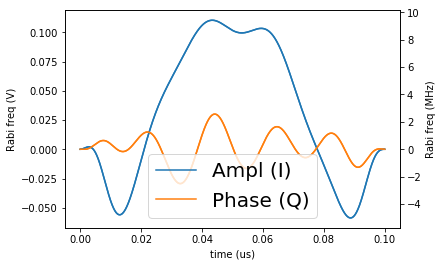

(0.110253256196438, 9.413219184502607)

In [46]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse.get_timegrid(unit='us')
t_phase = pulse.get_timegrid(unit='us')
try:
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')
    max_ampl = np.max([np.max(phase), np.max(amplitude)])
except ValueError:
    amplitude, phase, max_ampl = None, None, None
    
try:
    amplitude_rabi = pulse.get_data_ampl(unit='MHz')
    phase_rabi = pulse.get_data_phase(unit='MHz')
    max_rabi = np.max([np.max(amplitude_rabi), np.max(phase_rabi)])
except ValueError:
    amplitude_rabi, phase_rabi, max_rabi = None, None, None



try:
    #plt.figure(figsize=(10,6))
    fig, ax1 = plt.subplots()
    if amplitude is not None:
        ax1.plot(t_amplitude, amplitude, label="Ampl (I)")
        ax1.plot(t_phase, phase, label="Phase (Q)")
        ax1.set_ylabel("Rabi freq (V)")
        ax1.set_xlabel("time (us)")
    else:
        ax1.get_yaxis().set_visible(False)
        
    ax2 = ax1.twinx()
    if amplitude_rabi is not None:
        ax2.plot(t_amplitude, amplitude_rabi, label="Ampl (I)")
        ax2.plot(t_phase, phase_rabi, label="Phase (Q)")
        ax2.set_ylabel("Rabi freq (MHz)")
    else:
        ax2.get_yaxis().set_visible(False)
    
    # plt.plot(t_phase, phase+amplitude, label="I+Q")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")
    
    
max_ampl, max_rabi

In [47]:
0.2038719696/0.11025325

1.8491243532503578

# Parameters, Operators

In [8]:

simp = SimParameters()
simp.gamma_nv

2.8

# Measurements

In [ ]:
f_exp_mhz = 1e-6*exp_data[0,:] - (2710-2628)
f_exp_mhz_mirr = 1e-6*exp_data[0,:][::-1] - (2710-2628)
y_exp = (exp_data[1,:]*3.6)-2.55

In [ ]:


#get_f_limits(1e6*f_mw, 1e6*f_block, 1e6*df_block, symm_block=True)
#np.where(np.logical_and(freq_array >= 2700, freq_array <= 2720))

## Frequency Detuning

In [22]:

#B = 86.07
f_res = 2825e6
B = abs(f_res*1e-6-simp.D)/simp.gamma_nv
df = 150#120#120 # MHz

#f_block = (f_res - 93e6)*1e-6 # MHz
f_block = np.asarray([f_res*1e-6 - 95.6, 3018.4, 2935.6])
df_block = 10
fac_penalty = 100


symm_block = True
f_mw = simp.D-simp.gamma_nv * B

n_f = np.min([int(df/0.25), 500])
n_f= 150



sim = TimeDependentSimulation()

freq_array = np.linspace(simp.D - simp.gamma_nv * B - df, simp.D - simp.gamma_nv * B + df, n_f)

data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B, simp)

penalty = calc_crosstalk_penalty(1e6*freq_array, data_freq_detuning, 1e6*f_mw, 1e6*f_block, 1e6*df_block,
                                 symm_block=symm_block, fac_penalty=fac_penalty)


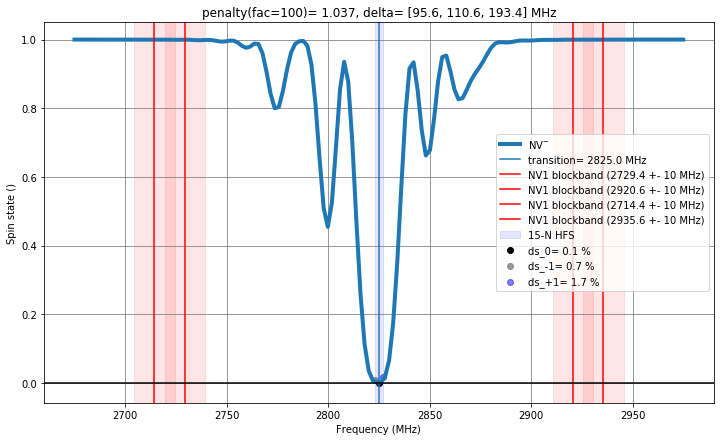

In [23]:
delta_hfs = 2.1 # MHz
f_mw = f_res*1e-6  # MHz

# value at the HFS values
vals = []
deltas = [0, -delta_hfs, delta_hfs]
for delta in deltas:
    idx = np.argmin(abs(freq_array-(f_mw+delta)))
    vals.append(data_freq_detuning[idx])


title_str = ""

# visualize the results
fig1, ax = plt.subplots(figsize=(12,7))
#mpl.rcParams['figure.dpi'] = 600

ax.plot(freq_array, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(freq_array+2*(B-B_nv2)/2*simp.gamma_nv, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(f_exp_mhz, y_exp, label="exp")
#ax.plot(f_exp_mhz_mirr, y_exp, label="mirrored(exp)")
#ax.set_xlim([2603,2653])

# vertical dots at values of HFS transitions
ax.scatter(f_mw+deltas[0], vals[0], color='black', label=f"ds_0= {1e2*vals[0]:.1f} %")
ax.scatter(f_mw+deltas[1], vals[1], color='grey', label=f"ds_-1= {1e2*vals[1]:.1f} %", alpha=0.8)
ax.scatter(f_mw+deltas[2], vals[2], color='blue', label=f"ds_+1= {1e2*vals[2]:.1f} %", alpha=0.5)

ax.axvline(f_mw, label=f"transition= {f_mw:.1f} MHz")
ax.axvspan(f_mw-2.1, f_mw+2.1, alpha=0.1, color='blue', label='15-N HFS')


# blockbands
f_lims = get_f_limits(1e6*f_mw, 1e6*f_block, 1e6*df_block, symm_block=symm_block)
for f_min, f_max in f_lims:
    f_center = (f_max + f_min) / 2
    if 1e-6*f_center > freq_array[0] and 1e-6*f_center < freq_array[-1]: 
        ax.axvline(1e-6*f_center, label=f"NV1 blockband ({1e-6*f_center:.1f} +- {df_block} MHz)", color='red')
        ax.axvspan(1e-6*f_min, 1e-6*f_max, alpha=0.1, color='red')

title_str += f"penalty(fac={fac_penalty})= {penalty:.3f}, delta= {sorted(np.around(abs(f_mw-f_block),decimals=2))} MHz"
        
# grid
ax.axhline(0, color='black')
#ax.axhline(1, color='black')
plt.grid(axis='x', color='0.5')
plt.grid(axis='y', color='0.5')




ax.set_xlabel(r'Frequency (MHz)')
ax.set_ylabel(r'Spin state ()')
plt.title(title_str)
ax.legend(loc='best', prop={'size': 10})
plt.show(fig1)

## Amplitude Error

In [25]:
B= 90 #gauss

sim = TimeDependentSimulation()

# scanned amplitude steps
amp_array = np.linspace(-0.35, 0.35, 50)
data_amp_detuning = sim.run_sim_ampsweep(amp_array, pulse, B, simp)



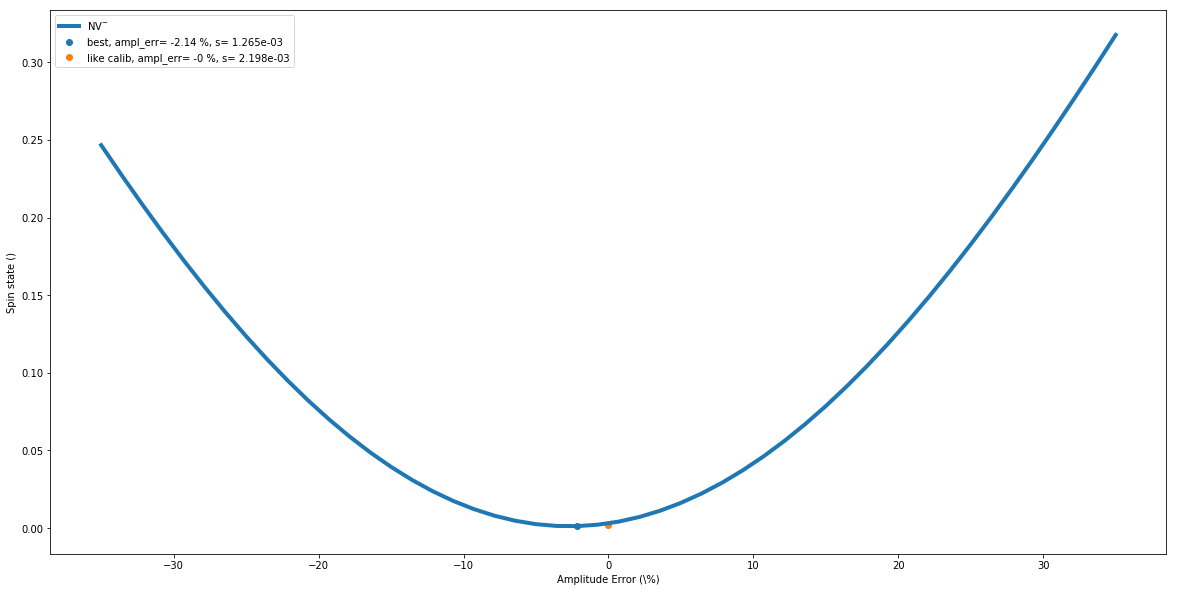

In [26]:
# visualize the results
fig2, ax = plt.subplots(figsize=(20,10))
ax.plot(amp_array*100, data_amp_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
ax.set_xlabel(r'Amplitude Error (\%)')
ax.set_ylabel(r'Spin state ()')

# value at the minimum
vals_x, vals_y = [], []
idx = np.argmin(data_amp_detuning)
vals_x.append(100*amp_array[idx])
vals_y.append(data_amp_detuning[idx])

plt.scatter(vals_x, vals_y, label=f"best, ampl_err= {vals_x[0]:.2f} %, s= {vals_y[0]:.3e}")

vals_x, vals_y = [], []
idx = np.argmin(abs(amp_array))
vals_x.append(amp_array[idx])
vals_y.append(data_amp_detuning[idx])

plt.scatter(vals_x, vals_y, label=f"like calib, ampl_err= {vals_x[0]:.0f} %, s= {vals_y[0]:.3e}")



plt.legend()
plt.show(fig2) 